In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

from scipy.stats import spearmanr
from scipy.stats import pearsonr

import seaborn as sns
import matplotlib.colors as mcolors

from bin import utils

In [2]:
fdata = ad.read_h5ad("./RNA/Multitime.clustered.h5")
cdata = ad.read_h5ad("./RNA/Multitime.guide.h5")

In [3]:
annotation = ad.read_h5ad("./RNA/Multitime.annotation.h5")

In [4]:
fdata, cdata = utils.align_rna_guide_data(fdata, cdata)

In [5]:
annotation.obs["cov"] = [tuple([array[0] // 100 * 100, array[1] // 100 * 100]) for array in annotation.obsm["spatial"]]

In [6]:
annotation.obs

,marker,annotations,cov
304204,1-1,Macrophages,"(6700, 400)"
28197,1-1,MuscleCell,"(600, 900)"
398689,1-1,Malignant,"(8700, 1500)"
417761,1-1,Fibroblast,"(9200, 1600)"
14623,1-1,Macrophages,"(300, 1800)"
...,...,...,...
400603-3,3-2,Others,"(12300, 2100)"
115137-5,3-2,Others,"(3500, 12300)"
93544-5,3-2,Others,"(2800, 7500)"
79352-5,3-2,Others,"(2400, 8300)"


# Cluster

### On cluster level, Macrophage colocalizes with T

In [7]:
annotation.obs["cov"] = [marker + "_" + str(array[0] // 100 * 100) + "-" + str(array[1] // 100 * 100) for marker, array in zip(annotation.obs["marker"], annotation.obsm["spatial"])]
fdata.obs["cov"] = [marker + "_" + str(array[0] // 100 * 100) + "-" + str(array[1] // 100 * 100) for marker, array in zip(fdata.obs["marker"], fdata.obsm["spatial"])]

In [8]:
annotation.obs

,marker,annotations,cov
304204,1-1,Macrophages,1-1_6700-400
28197,1-1,MuscleCell,1-1_600-900
398689,1-1,Malignant,1-1_8700-1500
417761,1-1,Fibroblast,1-1_9200-1600
14623,1-1,Macrophages,1-1_300-1800
...,...,...,...
400603-3,3-2,Others,3-2_12300-2100
115137-5,3-2,Others,3-2_3500-12300
93544-5,3-2,Others,3-2_2800-7500
79352-5,3-2,Others,3-2_2400-8300


In [27]:
map_df = fdata.obs[["cluster_cellcharter_givenk", "cov"]]
map_df.index = fdata.obs["cov"]
map_df = map_df.iloc[:, :-1].unstack()

In [28]:
map_dict = map_df["cluster_cellcharter_givenk"].to_dict()

In [29]:
annotation.obs["cluster"] = annotation.obs["cov"].map(map_dict)

In [36]:
annotation.obs.dtypes["cluster"] = "int"

In [91]:
c_df = annotation.obs.dropna()[["marker", "annotations", "cluster"]].groupby(["marker", "cluster"]).value_counts().unstack()

/tmp/ipykernel_75600/3576345416.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_df = annotation.obs.dropna()[["marker", "annotations", "cluster"]].groupby(["marker", "cluster"]).value_counts().unstack()


In [93]:
np.unique(c_df.index.get_level_values(0))

array(['1-1', '1-2', '2-1', '2-2', '3-1', '3-2'], dtype=object)

In [104]:
p_df

annotations,NK,effector T,stem-like T,memory T,exhausted T,Unknown T,DC,Macrophages,Epithelial,Malignant,Endothelial,Fibroblast,MuscleCell,Others
cluster,,,,,,,,,,,,,,
0.0,0.053884,0.043855,0.052467,0.042319,0.048657,0.050243,0.046789,0.038963,0.047619,0.058974,0.030451,0.026568,0.024411,0.029336
1.0,0.164934,0.174620,0.155834,0.165327,0.171820,0.172847,0.195784,0.182023,0.133333,0.140788,0.134996,0.124082,0.094622,0.088795
2.0,0.030498,0.016262,0.024276,0.022711,0.023315,0.032127,0.031733,0.021794,0.038095,0.015805,0.036143,0.032101,0.033474,0.070478
3.0,0.071389,0.142562,0.120595,0.127098,0.110492,0.069409,0.055996,0.096797,0.047619,0.089970,0.043824,0.065190,0.024572,0.012736
4.0,0.046772,0.084244,0.057165,0.069262,0.062342,0.039934,0.046268,0.055379,0.009524,0.053885,0.038674,0.037262,0.025418,0.016958
5.0,0.088895,0.037657,0.063430,0.036253,0.040041,0.074914,0.063351,0.052559,0.076190,0.041089,0.142586,0.115922,0.226828,0.208500
6.0,0.093818,0.057185,0.048551,0.042883,0.073492,0.086173,0.090914,0.053879,0.114286,0.085295,0.056203,0.049279,0.053132,0.069691
7.0,0.093135,0.089776,0.089272,0.098321,0.109985,0.102287,0.107360,0.098911,0.095238,0.157458,0.072648,0.066177,0.057966,0.078349
8.0,0.058260,0.021461,0.031323,0.019326,0.025849,0.054096,0.046442,0.034235,0.095238,0.026306,0.082498,0.098316,0.056999,0.181669


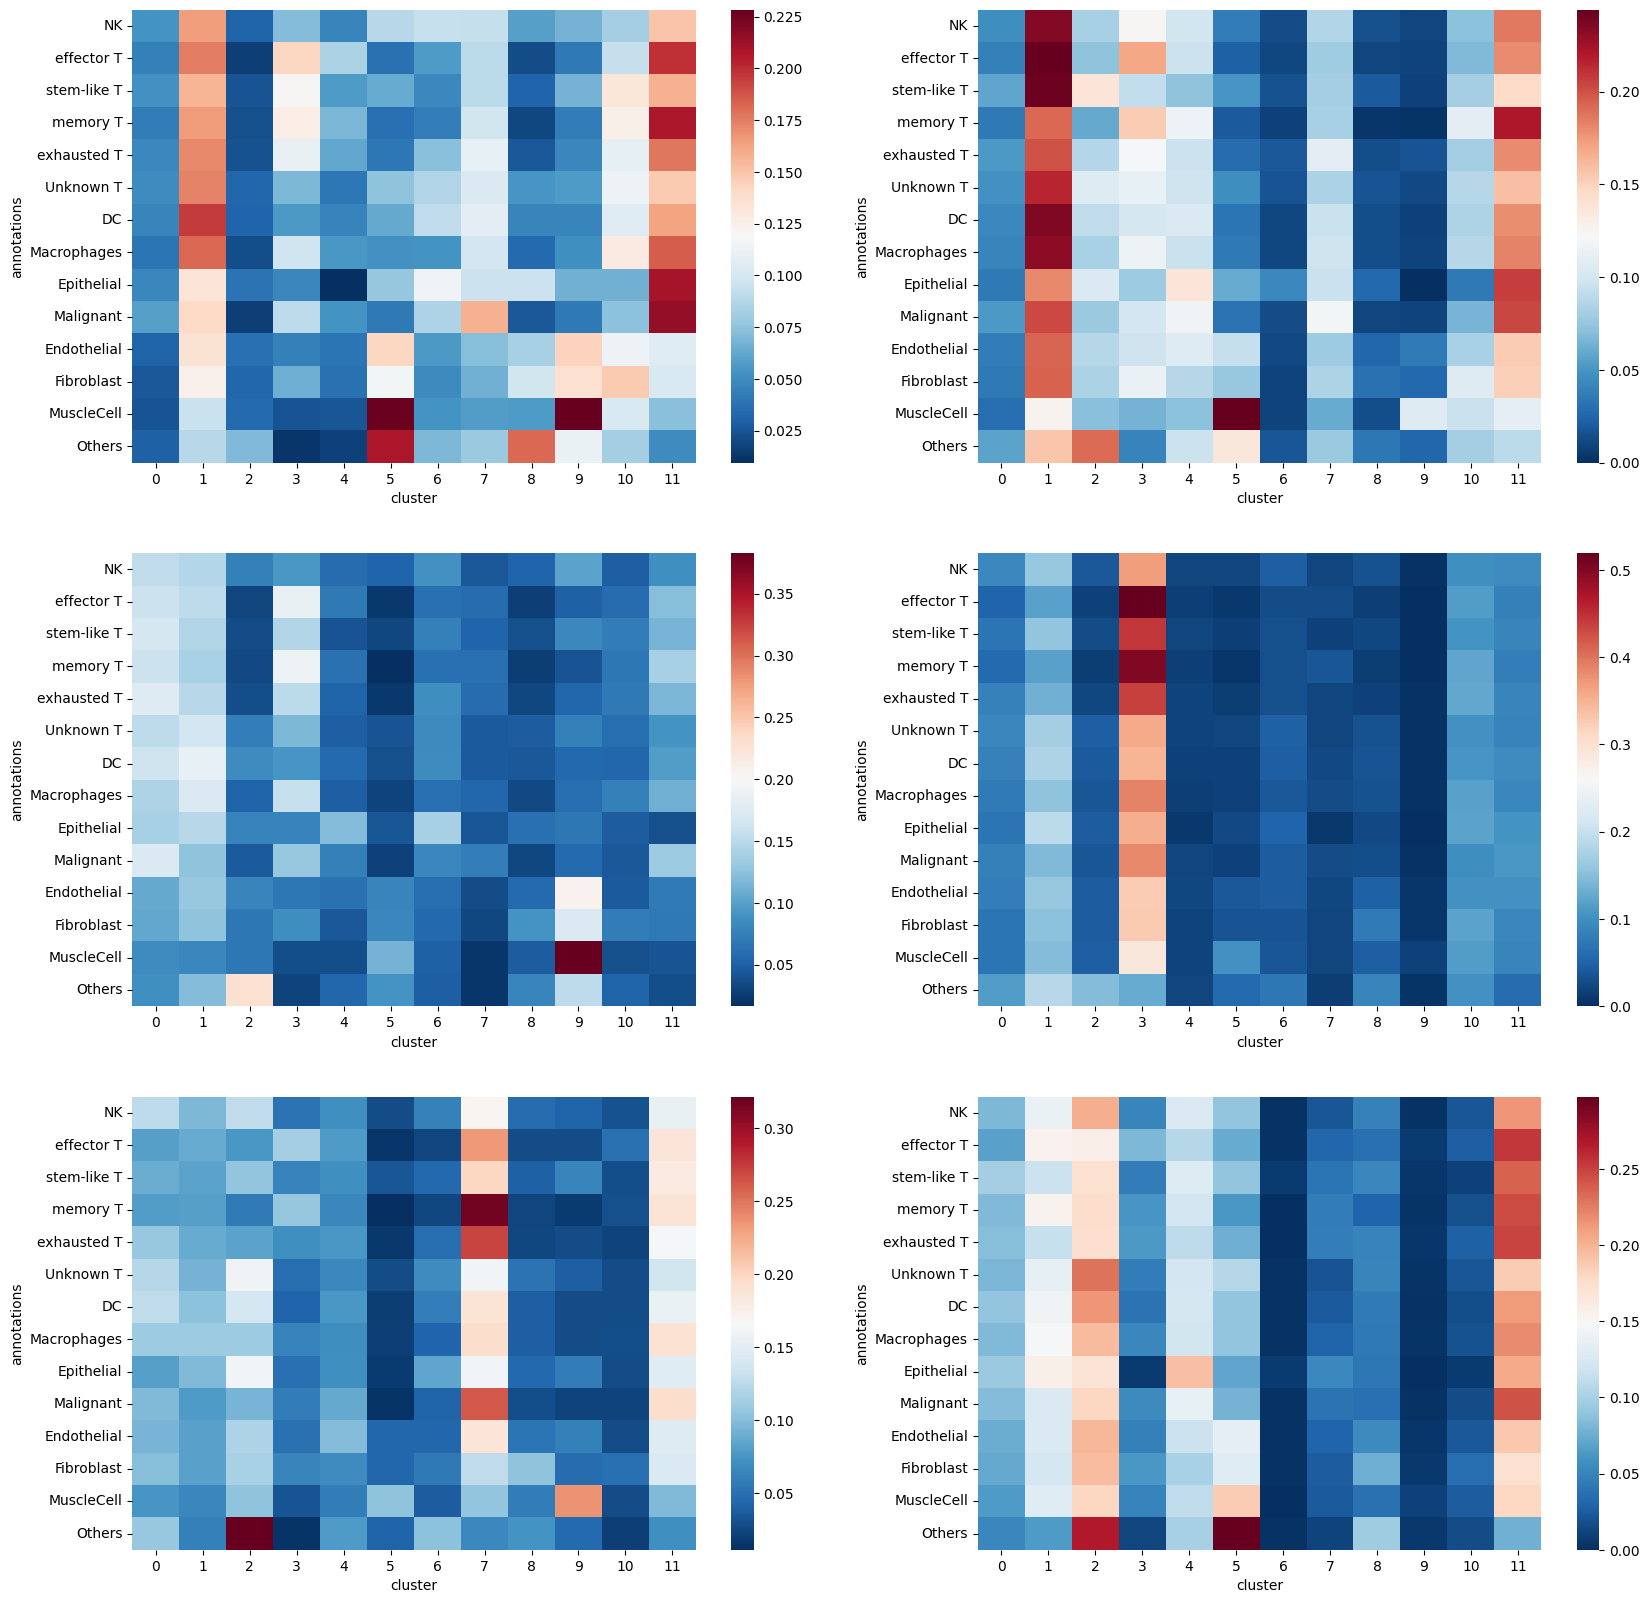

In [107]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
for idx, marker in enumerate(np.unique(c_df.index.get_level_values(0))):
    p_df = c_df.loc[marker].div(c_df.loc[marker].sum(), axis=1)
    p_df.index = p_df.index.astype(int)
    ax = axs[idx // 2, idx % 2]
    sns.heatmap(p_df.T, ax=ax, cmap="RdBu_r")

In [97]:
c_df.loc[marker].div(c_df.loc[marker].sum(), axis=1)

annotations,NK,effector T,stem-like T,memory T,exhausted T,Unknown T,DC,Macrophages,Epithelial,Malignant,Endothelial,Fibroblast,MuscleCell,Others
cluster,,,,,,,,,,,,,,
0.0,0.082373,0.067537,0.098394,0.082749,0.085852,0.080406,0.090317,0.082880,0.093567,0.084145,0.074582,0.072836,0.064402,0.051123
1.0,0.139025,0.155335,0.116466,0.154278,0.114873,0.134882,0.142282,0.146791,0.157895,0.126295,0.126859,0.123124,0.130754,0.064333
2.0,0.202620,0.158937,0.172691,0.176017,0.174123,0.229267,0.214667,0.195644,0.169591,0.180939,0.198386,0.195030,0.180772,0.267180
3.0,0.050024,0.081945,0.044177,0.061010,0.062878,0.044284,0.039303,0.051303,0.005848,0.054269,0.047320,0.062394,0.049740,0.012598
4.0,0.126558,0.106709,0.128514,0.121318,0.110036,0.121669,0.123033,0.119677,0.192982,0.136706,0.116427,0.100591,0.111451,0.099689
5.0,0.090579,0.074291,0.090361,0.062412,0.076179,0.106201,0.090463,0.089819,0.070175,0.078635,0.134697,0.131135,0.186526,0.297383
6.0,0.002051,0.001801,0.006024,0.000701,0.000000,0.001849,0.001757,0.001449,0.005848,0.001617,0.001671,0.001713,0.001114,0.001691
7.0,0.021619,0.031067,0.040161,0.044180,0.045949,0.020744,0.024372,0.028909,0.052632,0.039473,0.029856,0.024475,0.023571,0.011386
8.0,0.047657,0.036920,0.052209,0.030154,0.049577,0.050417,0.043548,0.042877,0.040936,0.036744,0.054582,0.075578,0.038048,0.096347


# Neighbor

### Bin20 neighbor distribution

In [9]:
def extract_bin20(bin20_data, bin100_masked_data, replace_obs=None):

    try:
        bin100_mask = bin100_masked_data.obs["spatial_cov"].tolist()
        mask = [array in bin100_mask for array in bin20_data.obs["spatial_cov"]]
    except:
        bin20_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin20_data.obsm["spatial"]]
        bin100_masked_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin100_masked_data.obsm["spatial"]]
        mask = [array in bin100_masked_data.obs["spatial_cov"].tolist() for array in tqdm(bin20_data.obs["spatial_cov"])]

    if replace_obs:
        for obj in replace_obs:
            spatial_to_obs = dict(zip(bin100_masked_data.obs["spatial_cov"], bin100_masked_data.obs[obj]))
            bin20_data.obs[obj] = bin20_data.obs["spatial_cov"].map(spatial_to_obs)
    return bin20_data[mask].copy()

def extract_bin100(bin100_data, bin20_masked_data):

    try:
        bin20_mask = bin20_masked_data.obs["spatial_cov"].unique().tolist()
        mask = [array in bin20_mask for array in bin100_data.obs["spatial_cov"]]
    except:
        bin100_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin100_data.obsm["spatial"]]
        bin20_masked_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin20_masked_data.obsm["spatial"]]
        bin20_mask = bin20_masked_data.obs["spatial_cov"].unique().tolist()
        mask = [array in bin20_mask for array in bin100_data.obs["spatial_cov"]]
    return bin100_data[mask].copy()

def find_near(bin100, bin100_data, border=1, bin_size=100):
    #print("center of bin is ", bin100.obsm["spatial"][0])
    cmin = ((bin100.obsm["spatial"] // bin_size - border) * bin_size)[0]
    cmax = ((bin100.obsm["spatial"] // bin_size + border + 1) * bin_size)[0]
    #print("extracting bin from ", cmin, "to", cmax)
    mask = [cmin[0] <= array[0] <= cmax[0] and cmin[1] <= array[1] <= cmax[1] for array in bin100_data.obsm["spatial"]]
    return bin100_data[mask]

In [10]:
fdata.obs

,marker,n_genes,n_counts,_scvi_batch,_scvi_labels,cluster_cellcharter_givenk,cov
cov,,,,,,,
1-1_10049-10049,1-1,2413,6872,0,0,0,1-1_10000-10000
1-1_10049-10149,1-1,2616,7885,0,0,0,1-1_10000-10100
1-1_10049-10249,1-1,2129,5163,0,0,0,1-1_10000-10200
1-1_10049-10349,1-1,2012,4589,0,0,11,1-1_10000-10300
1-1_10049-10449,1-1,2331,5825,0,0,4,1-1_10000-10400
...,...,...,...,...,...,...,...
3-2_9949-9549,3-2,1189,2305,5,0,11,3-2_9900-9500
3-2_9949-9649,3-2,903,1586,5,0,11,3-2_9900-9600
3-2_9949-9749,3-2,1103,2096,5,0,3,3-2_9900-9700


In [11]:
annotation.obs

,marker,annotations,cov
304204,1-1,Macrophages,1-1_6700-400
28197,1-1,MuscleCell,1-1_600-900
398689,1-1,Malignant,1-1_8700-1500
417761,1-1,Fibroblast,1-1_9200-1600
14623,1-1,Macrophages,1-1_300-1800
...,...,...,...
400603-3,3-2,Others,3-2_12300-2100
115137-5,3-2,Others,3-2_3500-12300
93544-5,3-2,Others,3-2_2800-7500
79352-5,3-2,Others,3-2_2400-8300


# Cluster interaction

In [19]:
from pysal.lib import weights
from sklearn.metrics import pairwise_distances

In [18]:
w_map = weights.DistanceBand.from_array(annotation.obsm["spatial"], threshold=25)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 84273 disconnected components.
 There are 51772 islands with ids: 0, 6, 7, 9, 10, 15, 19, 21, 29, 31, 32, 43, 44, 45, 46, 53, 65, 66, 78, 83, 93, 96, 101, 126, 128, 129, 134, 135, 145, 147, 152, 159, 166, 172, 176, 180, 189, 194, 195, 198, 199, 205, 215, 225, 228, 229, 234, 237, 251, 253, 257, 258, 261, 272, 275, 278, 284, 286, 299, 300, 308, 313, 314, 316, 330, 332, 336, 337, 339, 342, 343, 346, 350, 353, 354, 355, 356, 358, 360, 361, 362, 363, 365, 366, 370, 371, 379, 381, 382, 383, 384, 385, 386, 387, 393, 396, 398, 428, 431, 447, 449, 478, 534, 536, 549, 550, 554, 567, 572, 574, 577, 579, 580, 586, 590, 596, 600, 604, 610, 620, 622, 627, 631, 636, 641, 646, 649, 661, 665, 670, 671, 679, 687, 689, 697, 709, 710, 711, 715, 725, 730, 731, 732, 744, 753, 754, 758, 759, 762, 763, 766, 783, 786, 799, 803, 805, 809, 814, 816, 820, 

In [113]:
annotation = annotation[~annotation.obs["cluster"].isna()]

In [32]:
annotation_ = annotation[(annotation.obs["marker"] == "1-1") & (annotation.obs["cluster"] == 3)]

t_cell_idx = np.where(annotation_.obs["annotations"].str.endswith("T"))
m_cell_idx = np.where(annotation_.obs["annotations"] == "Macrophages")

coords = annotation_.obsm["spatial"]
distances = pairwise_distances(coords[t_cell_idx], coords[m_cell_idx])

In [94]:
interaction_threshold = 30

In [38]:
interactions = np.sum(distances < interaction_threshold)
interactions

37718

In [114]:
i_dict = {}
for marker in np.unique(annotation.obs["marker"]):
    i_dict[marker] = {}
    for cluster in tqdm(np.unique(annotation.obs["cluster"])):
        annotation_ = annotation[(annotation.obs["marker"] == marker) & (annotation.obs["cluster"] == cluster)]
        t_cell_idx = np.where(annotation_.obs["annotations"].str.endswith("T"))[0]
        m_cell_idx = np.where(annotation_.obs["annotations"] == "Macrophages")[0]
        if len(t_cell_idx) == 0 or len(m_cell_idx) == 0:
            i_dict[marker][cluster] = 0
            continue
        coords = annotation_.obsm["spatial"]
        distances = pairwise_distances(coords[t_cell_idx], coords[m_cell_idx])
        interactions = np.sum(distances < interaction_threshold)
        i_dict[marker][cluster] = interactions

100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


In [119]:
interact_p_df = (pd.DataFrame(i_dict) / m_cdf).dropna()

<Axes: >

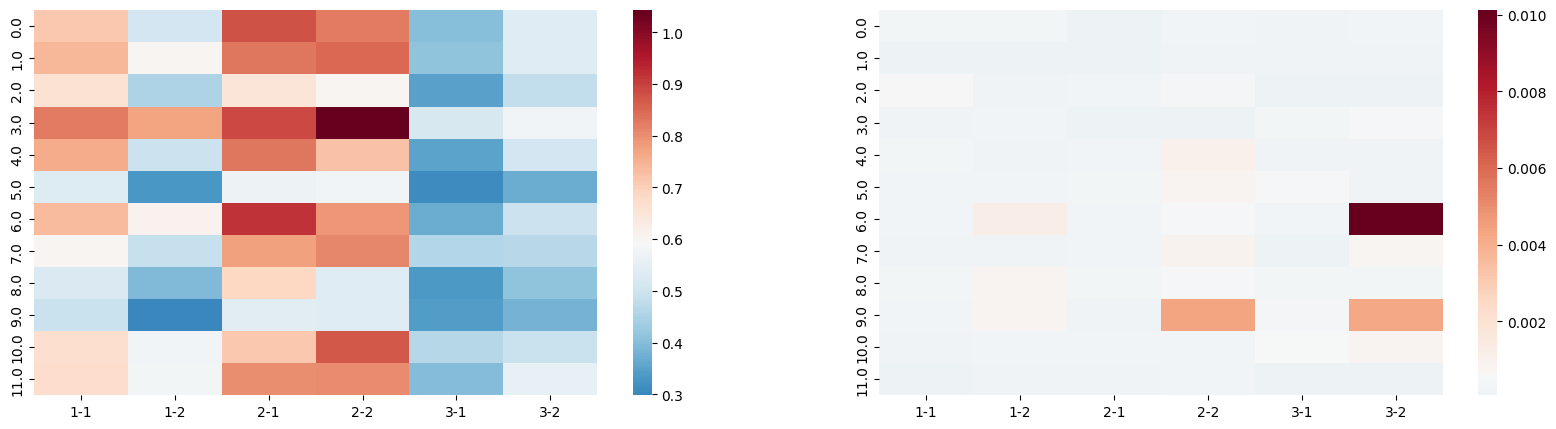

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.heatmap(interact_p_df, center=np.mean(interact_p_df), cmap="RdBu_r", ax=ax[0])
sns.heatmap(interact_p_df / t_cdf, center=np.mean(interact_p_df / t_cdf), cmap="RdBu_r", ax=ax[1])

In [126]:
d_dict = {}
for marker in np.unique(annotation.obs["marker"]):
    d_dict[marker] = {}
    for cluster in tqdm(np.unique(annotation.obs["cluster"])):
        annotation_ = annotation[(annotation.obs["marker"] == marker) & (annotation.obs["cluster"] == cluster)]
        t_cell_idx = np.where(annotation_.obs["annotations"].str.endswith("T"))[0]
        m_cell_idx = np.where(annotation_.obs["annotations"] == "DC")[0]
        if len(t_cell_idx) == 0 or len(m_cell_idx) == 0:
            d_dict[marker][cluster] = 0
            continue
        coords = annotation_.obsm["spatial"]
        distances = pairwise_distances(coords[t_cell_idx], coords[m_cell_idx])
        interactions = np.sum(distances < interaction_threshold)
        d_dict[marker][cluster] = interactions

100%|██████████| 12/12 [00:01<00:00,  6.42it/s]


In [127]:
c_cdf = annotation.obs[["annotations", "cluster", "marker"]].groupby(["cluster", "marker"]).value_counts().unstack()
d_cdf = c_cdf["DC"].unstack()
t_cdf = c_cdf.loc[:, c_cdf.columns.str.endswith("T")].sum(axis=1).unstack()

/tmp/ipykernel_16544/776427906.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_cdf = annotation.obs[["annotations", "cluster", "marker"]].groupby(["cluster", "marker"]).value_counts().unstack()


In [130]:
print(annotation.obs["annotations"].unique().tolist())

['Macrophages', 'MuscleCell', 'Malignant', 'Fibroblast', 'memory T', 'effector T', 'stem-like T', 'Unknown T', 'Endothelial', 'Others', 'DC', 'NK', 'exhausted T', 'Epithelial']


In [128]:
f_dict = {}
for marker in np.unique(annotation.obs["marker"]):
    f_dict[marker] = {}
    for cluster in tqdm(np.unique(annotation.obs["cluster"])):
        annotation_ = annotation[(annotation.obs["marker"] == marker) & (annotation.obs["cluster"] == cluster)]
        t_cell_idx = np.where(annotation_.obs["annotations"].str.endswith("T"))[0]
        m_cell_idx = np.where(annotation_.obs["annotations"] == "Fibroblast")[0]
        if len(t_cell_idx) == 0 or len(m_cell_idx) == 0:
            f_dict[marker][cluster] = 0
            continue
        coords = annotation_.obsm["spatial"]
        distances = pairwise_distances(coords[t_cell_idx], coords[m_cell_idx])
        interactions = np.sum(distances < interaction_threshold)
        f_dict[marker][cluster] = interactions

100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


In [131]:
e_dict = {}
for marker in np.unique(annotation.obs["marker"]):
    e_dict[marker] = {}
    for cluster in tqdm(np.unique(annotation.obs["cluster"])):
        annotation_ = annotation[(annotation.obs["marker"] == marker) & (annotation.obs["cluster"] == cluster)]
        t_cell_idx = np.where(annotation_.obs["annotations"].str.endswith("T"))[0]
        m_cell_idx = np.where(annotation_.obs["annotations"] == "Endothelial")[0]
        if len(t_cell_idx) == 0 or len(m_cell_idx) == 0:
            e_dict[marker][cluster] = 0
            continue
        coords = annotation_.obsm["spatial"]
        distances = pairwise_distances(coords[t_cell_idx], coords[m_cell_idx])
        interactions = np.sum(distances < interaction_threshold)
        e_dict[marker][cluster] = interactions

100%|██████████| 12/12 [00:02<00:00,  5.34it/s]


In [152]:
m_dict = {}
for marker in np.unique(annotation.obs["marker"]):
    m_dict[marker] = {}
    for cluster in tqdm(np.unique(annotation.obs["cluster"])):
        annotation_ = annotation[(annotation.obs["marker"] == marker) & (annotation.obs["cluster"] == cluster)]
        t_cell_idx = np.where(annotation_.obs["annotations"].str.endswith("T"))[0]
        m_cell_idx = np.where(annotation_.obs["annotations"] == "Malignant")[0]
        if len(t_cell_idx) == 0 or len(m_cell_idx) == 0:
            m_dict[marker][cluster] = 0
            continue
        coords = annotation_.obsm["spatial"]
        distances = pairwise_distances(coords[t_cell_idx], coords[m_cell_idx])
        interactions = np.sum(distances < interaction_threshold)
        m_dict[marker][cluster] = interactions

100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


In [159]:
r_dict = {}
for marker in np.unique(annotation.obs["marker"]):
    r_dict[marker] = {}
    for cluster in tqdm(np.unique(annotation.obs["cluster"])):
        annotation_ = annotation[(annotation.obs["marker"] == marker) & (annotation.obs["cluster"] == cluster)]
        t_cell_idx = np.where(annotation_.obs["annotations"].str.endswith("T"))[0]
        m_cell_idx = np.where(annotation_.obs["annotations"] == "Epithelial")[0]
        if len(t_cell_idx) == 0 or len(m_cell_idx) == 0:
            r_dict[marker][cluster] = 0
            continue
        coords = annotation_.obsm["spatial"]
        distances = pairwise_distances(coords[t_cell_idx], coords[m_cell_idx])
        interactions = np.sum(distances < interaction_threshold)
        r_dict[marker][cluster] = interactions

100%|██████████| 12/12 [00:00<00:00, 34.27it/s]


In [160]:
endo_vec = pd.DataFrame(e_dict).values.flatten()
fibro_vec = pd.DataFrame(f_dict).values.flatten()
macro_vec = pd.DataFrame(i_dict).values.flatten()
dc_vec = pd.DataFrame(d_dict).values.flatten()
m_vec = pd.DataFrame(m_dict).values.flatten()
epth_vec = pd.DataFrame(r_dict).values.flatten()

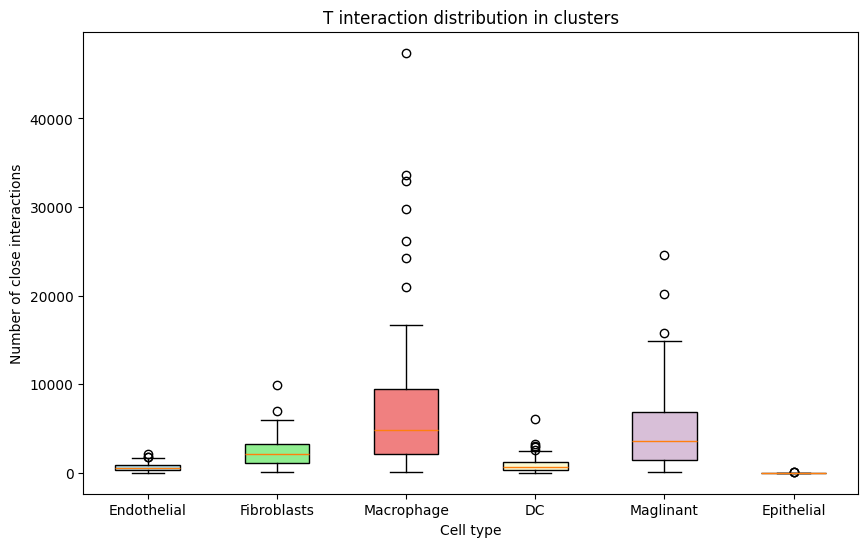

In [162]:
vec = [endo_vec, fibro_vec, macro_vec, dc_vec, m_vec, epth_vec]

fig, ax = plt.subplots(figsize=(10, 6))
box = ax.boxplot(vec, patch_artist=True)

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightgoldenrodyellow', 'thistle', 'red']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_xticklabels(["Endothelial", "Fibroblasts", "Macrophage", "DC", "Maglinant", "Epithelial"])

ax.set_title("T interaction distribution in clusters")
ax.set_xlabel("Cell type")
ax.set_ylabel("Number of close interactions")

plt.show()